In [1]:
import os
import warnings
import pprint

import xarray as xr
import numpy as np
import toml
import torch
from scipy.ndimage import gaussian_filter, gaussian_filter1d

import libVoodoo.TorchModel as TM
import libVoodoo.Loader as Loader

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore")

NCLASSES = 3
p = 0.4

model_setup_file = f'VnetSettings-1.toml'
torch_settings = toml.load(os.path.join(model_setup_file))['pytorch']

In [2]:
import datetime
def dt_to_ts(dt):
    """datetime to unix timestamp"""
    # return dt.replace(tzinfo=datetime.timezone.utc).timestamp()
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def ts_to_dt(ts):
    """unix timestamp to dt"""
    return datetime.datetime.utcfromtimestamp(ts)

def decimalhour2unix(dt, time):
    return np.array([x*3600. + dt_to_ts(datetime.datetime(int(dt[:4]), int(dt[4:6]), int(dt[6:]), 0, 0, 0)) for x in time]).astype(int).astype( 'datetime64[s]')

def lin2z(array):
    """linear values to dB (for np.array or single number)"""
    return 10 * np.ma.log10(array)

def open_xarray_datasets(path):
    import re
    ds = xr.open_mfdataset(path, parallel=True, decode_times=False, )
    x = re.findall("\d{8}", path)[0]
    # convert time to unix
    ds = ds.assign_coords(time = decimalhour2unix(str(x), ds['time'].values))
    ds['time'].attrs['units'] = 'Unix Time: Seconds since January 1st, 1970'


    return ds

In [3]:
def VoodooPredictor(X):
    """
    Predict probability disribution over discrete set of 3 classes (dummy, CD, non-CD) .
    
    Args:
        X: list of [256, 6, 1] time spectrograms, dimensitons: (N_Doppler_bins, N_time_steps, N_range_gate)
        
        
    Return:
        predicitons: list of predictions 
    """
    torch_settings.update({'dev': 'cpu'})
    #trained_model = 'Vnet0x60de1687-fnX-gpu0-VN.pt' 
    trained_model = 'Vnet0x615580bf-fn1-gpu0-VN.pt'

    print(f'Loading Vnet model ...... {model_setup_file}')

    # (n_samples, n_Doppler_bins, n_time_steps)
    X = X[:, :, :, np.newaxis]
    X = X.transpose(0, 3, 2, 1)
    X_test = torch.Tensor(X)

    model = TM.VoodooNet(X_test.shape, NCLASSES, **torch_settings)
    model.load_state_dict(torch.load(trained_model, map_location=model.device)['state_dict'])

    prediction = model.predict(X_test, batch_size=256)
    prediction = prediction.to('cpu')
    return prediction

In [4]:
os.getcwd()

'/Users/willi/code/python/voodoo_release/Voodoo'

# KAZR test

In [5]:
#Z_min, Z_max = -100, -50
#data_path = 'example_data/KAZR/'
#spectra_file_name = 'nsakazrspeccmaskgecopolC1.a0.20190127.050006.cdf'
#lidar_file_name = 'nsahsrlC1.a1.20190127.000000.nc'


#data = xr.open_mfdataset(data_path+spectra_file_name)
#data['time'] = data['time_offset']# integral of spectral bin power

## get nonzero mask
#nonzeros_mask = data['locator_mask'].values > -1

#fake_Z = TM.VoodooNet.reshape3d(data['spectra'].values, ~nonzeros_mask)
#fake_Z = np.ma.masked_where(~nonzeros_mask, np.sum(10**(fake_Z/10), axis=2)).T
#fake_Z = 10*np.log10(fake_Z)
#print(fake_Z.min(), fake_Z.max())

#data['spectra']
#spectra_list = data['spectra'].values.copy()
#spectra_list = gaussian_filter1d(data['spectra'].values.copy(), sigma=1)
#spectra_list = gaussian_filter1d(data['spectra'].values.copy(), sigma=2)

## normalize between 0 and 1
#spectra_norm = (spectra_list - Z_min) / (Z_max - Z_min)
#plt.plot(spectra_norm[1000, :,])

#print(spectra_norm.min(), spectra_norm.max())

#X = np.zeros((spectra_norm.shape)+(6,))
#for i in range(spectra_norm.shape[0]):
#    for j in range(6):
#        X[i, :, j] = spectra_norm[i, :]

#hsrl = xr.open_mfdataset(data_path+lidar_file)
#backscatter = hsrl['beta_a_backscatter'].copy()
#backscatter = backscatter.sel(time=slice('2019-01-27T05:00:00', '2019-01-27T06:00:00'))
#backscatter

# RPG-FMCW94 test

In [6]:
from rpgpy import read_rpg
from rpgpy.spcutil import spectra2moments

data_path = 'example_data/RPG-FMCW94/'
file_name = '190801_060001_P05_ZEN.LV0'
Z_min, Z_max = -50, 20
cat_file_name = '20190801-punta-arenas-categorize-limrad94.nc'
rpg_lv0_header, rpg_lv0_data = read_rpg(data_path+file_name)


In [7]:
moments = spectra2moments(rpg_lv0_data, rpg_lv0_header)

In [8]:
# replace fill values
nonzeros_spectra = rpg_lv0_data['TotSpec'] > 0.0
rpg_spectra_vh = Loader.replace_fill_value(rpg_lv0_data['TotSpec'], rpg_lv0_data['SLv'])
rpg_spectra_h = Loader.replace_fill_value(rpg_lv0_data['HSpec'], rpg_lv0_data['SLh'])
rpg_spectra_vh.shape

(671, 292, 256)

In [9]:
print(rpg_spectra_vh.min())
print(rpg_spectra_vh.max())

1.8686171e-07
2.3624246


In [10]:
# time since 2001-01-01 to UNIX to numpy.datetime64
ts_list = rpg_lv0_data['Time'] + dt_to_ts(datetime.datetime(2001, 1, 1))
dt_list = [ts_to_dt(ts) for ts in ts_list]
np_dt_list = np.array([np.datetime64(ts,'s') for ts in dt_list])
t0_radar, t1_radar = np_dt_list[0], np_dt_list[-1]

In [11]:
#  input categorize data
try:
    # slice clounet categorize file 
    cn_data = open_xarray_datasets(data_path+cat_file_name)
    cn_data = cn_data.sel(time=slice(t0_radar, t1_radar))
    ts_main = [get_unixtime(ts.values) for ts in cn_data['time']]
    
except Exception as e:
    ts_main = np.arange(ts_list[0], ts_list[-1], 30.0)


# preprocess spectra
interp_var, interp_mask = Loader.hyperspectralimage(
    ts_list,
    rpg_spectra_vh,
    rpg_spectra_h,
    nonzeros_spectra,
    6,
    ts_main
)

interp_var.shape

nonzeros_mask = (interp_mask.any(axis=3)).any(axis=2)
spectra_orig = interp_var.copy()

In [12]:
spectra_list = []
for ind_t in range(nonzeros_mask.shape[0]):
    for ind_h in range(nonzeros_mask.shape[1]):
        if nonzeros_mask[ind_t, ind_h]:
            spectra_list.append(interp_var[ind_t, ind_h, :, :, 0])
            
spectra_list = np.array(spectra_list)
spectra_list = lin2z(spectra_list) 

-0.24651217 0.7676226


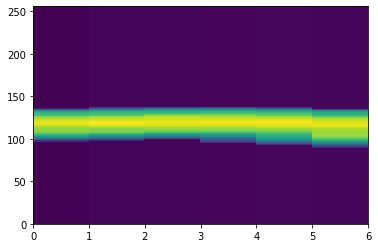

In [13]:
# normalize between 0 and 1
spectra_norm = (spectra_list - Z_min) / (Z_max - Z_min)
X = spectra_norm

plt.pcolormesh(spectra_norm[1000, :, :])
print(spectra_norm.min(), spectra_norm.max())

In [14]:
# slice

In [15]:
prediction = VoodooPredictor(X)

Loading Vnet model ...... VnetSettings-1.toml


In [16]:
# smooth predictions
prediction_smoothed = np.zeros((nonzeros_mask.shape)+(3,))
for i in range(NCLASSES):
    _tmp = TM.VoodooNet.reshape(prediction[:, i], ~nonzeros_mask)
    _tmp = gaussian_filter(_tmp, sigma=1)
    prediction_smoothed[:, :, i] = np.ma.masked_where(~nonzeros_mask, _tmp)
    

In [17]:
# VOODOO cloud droplet likelyhood colorbar (viridis + grey below minimum value)
from matplotlib import cm
from matplotlib.colors import ListedColormap
viridis = cm.get_cmap('viridis', 8)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[:1, :] = np.array([220/256, 220/256, 220/256, 1])
p_cmap = ListedColormap(newcolors)



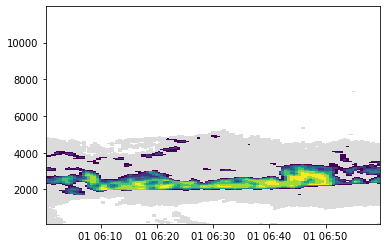

In [18]:
plt.pcolormesh(
    cn_data['time'],
    cn_data['height'],
    np.ma.masked_where(~nonzeros_mask, prediction_smoothed[:, :, 1]).T, 
    vmin=p, vmax=1, 
    cmap=p_cmap
)